# Simple Koopman pipeline

This example uses simulation data from a simple mass-spring-damper to demonstrate how to use `KoopmanPipeline`, the most important class in `pykoop`. A Koopman pipeline consists of a set of lifting functions, which transform states into a higher dimensional space, and a regressor, that performs linear regression in that space.

In [1]:
# Imports
from matplotlib import pyplot as plt
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

import pykoop

# Set plot defaults
plt.rc('lines', linewidth=2)
plt.rc('axes', grid=True)
plt.rc('grid', linestyle='--')

Load example data from the library. `eg` is a `dict` containing training data, validation data, and a few related parameters.

In [2]:
eg = pykoop.example_data_msd()

Create the Koopman pipeline. It accepts a list of lifting functions, which are composed to form the final transformation. Each lifting function has a string name, which can be used for cross-validating over lifting function parameters.

In [3]:
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('pl', pykoop.PolynomialLiftingFn(order=2)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler())),
    ],
    regressor=pykoop.Edmd(alpha=1),
)

Fit the pipeline. The data format consists of an optional episode feature, which groups individual experiments, states, and exogenous inputs. The `fit()` method needs to know if there is an episode feature, and how many inputs there are.

In [4]:
kp.fit(
    eg['X_train'],
    n_inputs=eg['n_inputs'],
    episode_feature=eg['episode_feature'],
)

KoopmanPipeline(lifting_functions=[('ma',
                                    SkLearnLiftingFn(transformer=MaxAbsScaler())),
                                   ('pl', PolynomialLiftingFn(order=2)),
                                   ('ss',
                                    SkLearnLiftingFn(transformer=StandardScaler()))],
                regressor=Edmd(alpha=1))

This is the matrix approximation of the Koopman operator. It needs to be transposed because `scikit-learn` puts time on the first axis and features on the second.

In [5]:
kp.regressor_.coef_.T

array([[ 9.83821877e-01,  7.37395653e-02,  1.14097993e-03,
         3.56958678e-04, -1.31762746e-02,  2.69532030e-02,
        -2.12135080e-03,  1.96144371e-02, -7.31646538e-03],
       [-1.51394823e-01,  8.44690217e-01,  1.40948997e-04,
        -6.45670543e-03, -2.39662729e-02,  1.77247216e-01,
         4.60499946e-03,  3.76649110e-02, -1.53728812e-02],
       [ 1.16916967e-03,  2.29797118e-04,  9.58696283e-01,
         9.28153811e-02,  1.75676259e-02,  3.23235312e-04,
         7.60167038e-02, -2.28520931e-03, -8.46063574e-03],
       [-3.81899442e-04, -7.09619495e-03, -1.96816403e-01,
         7.84429668e-01,  6.79723612e-02,  8.86434652e-03,
         2.05522321e-01,  7.49812518e-02, -1.85952809e-02],
       [-3.65272037e-03, -1.08771186e-02,  3.38235034e-02,
        -1.83559626e-01,  6.86068831e-01,  1.16734342e-02,
        -6.15615705e-02,  3.28055216e-01, -4.72169811e-03]])

Given the fit pipeline, predict the system's response to new initial conditions and inputs.

In [6]:
X_pred = kp.predict_trajectory(eg['x0_valid'], eg['u_valid'])

Score the episode against a validation set.

In [7]:
score = kp.score(eg['X_valid'])

Plot the prediction versus the validation set.

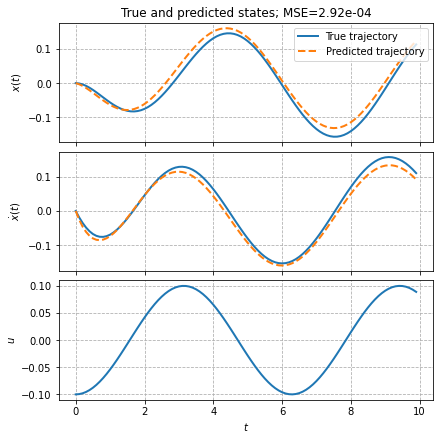

In [8]:
fig, ax = plt.subplots(
    kp.n_states_in_ + kp.n_inputs_in_,
    1,
    constrained_layout=True,
    sharex=True,
    figsize=(6, 6),
)
# Plot true trajectory
ax[0].plot(eg['t'], eg['X_valid'][:, 1], label='True trajectory')
ax[1].plot(eg['t'], eg['X_valid'][:, 2])
ax[2].plot(eg['t'], eg['X_valid'][:, 3])
# Plot predicted trajectory
ax[0].plot(eg['t'], X_pred[:, 1], '--', label='Predicted trajectory')
ax[1].plot(eg['t'], X_pred[:, 2], '--')
# Add labels
ax[-1].set_xlabel('$t$')
ax[0].set_ylabel('$x(t)$')
ax[1].set_ylabel(r'$\dot{x}(t)$')
ax[2].set_ylabel('$u$')
ax[0].set_title(f'True and predicted states; MSE={-1 * score:.2e}')
ax[0].legend(loc='upper right')